# TeamBadass Milestone 2

This notebook intends to explore and describe the relevant aspects of our data sets, preprocess it, and perform some initial analysis. The first part of the notebook contains the loading of data and some general preprocessing used throughout the notebook. The rest of the notebook is divided into the five research questions specified in [**README**](https://github.com/epfl-ada/ada-2022-project-teambadass/blob/main/README.md). Each section contains specific preprocessing for the task and necessary statistics and plots. The initial analysis we have performed intends to give us a clue whether our choice of methods is reasonable and sound. 

---
**Contents of notebook:**
- [Data Processing](#Data-Processing)
  - [Loading data](#Loading-data)
  - [Removing null values](#Removing-null-values)
- [Release Date](#Release-Date)
  - [Data Processing](#Data-Processing)
  - [Plots - Year](#Plots---Year)
  - [Plots - Month](#Plots---Month)
  - [Adjusting for Inflation](#Adjusting-for-Inflation)
  - [Statistics](#Statistics)
- [Diversity](#Diversity)
  - [Distributions](#Distributions)
  - [Ethnicities](#Ethnicities)
- [Cast](#Cast)
  - [Preprocessing](#Preprocessing)
  - [Understanding Cast Data](Understanding-Cast-Data)
  - [Exploring Method: Linear Regression](#Exploring-Method:-Linear-Regression)
- [Runtime](#Runtime)
  - [Data Preprocessing](#Data-Preprocessing)
  - [Distribution of runtime](#Distribution-of-runtime)
  - [Regression & Scatterplot](#Regression-&-Scatterplot)
  - [Effect of short runtime on revenue](#Effect-of-short-runtime-on-revenue)
  - [Difference in runtime between blockbuster vs. non-blockbuster](#Difference-in-runtime-between-blockbuster-vs.-non-blockbuster)
- [Plot Summary](#Plot-Summary)
  - [Data Processing](#Data-Processing)
  - [Regression & Scatterplot](#Regression-&-Scatterplot)
  - [Difference in revenues between movies with more positive and more negative plot](#Difference-in-revenues-between-movies-with-more-positive-and-more-negative-plot)
  - [Difference in sentiment proportion between blockbuster vs. non-blockbuster](#Difference-in-sentiment-proportion-between-blockbuster-vs.-non-blockbuster)

---
## Data Processing

---
### Loading data

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import requests
from datetime import datetime as dt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from helpers import *

In [3]:
# turn off warning
# pd.options.mode.chained_assignment = None

In [4]:
# constants

# data folder
DATA_FOLDER = "./data/"

# google disk
MOVIE_PATH = get_path(
    "https://drive.google.com/file/d/18ZLIKZsH41qls54Gy1qSYW1xtovf9Ke9/view?usp=share_link"
)
CHARACTER_PATH = get_path(
    "https://drive.google.com/file/d/1b3_Jn3bBJl6prrtPagU-Yol-ijFMod2u/view?usp=share_link"
)
RATING_PATH = get_path(
    "https://drive.google.com/file/d/1Dj5PhOERTTv6zZDprLIQMMaot3JYFlWi/view?usp=share_link"
)
BUDGET_PATH = get_path(
    "https://drive.google.com/file/d/1pV-iP36u1wmELu3AOLPNZ7rJJGsgj7YB/view?usp=share_link"
)
INFLATION_PATH = get_path(
    "https://drive.google.com/file/d/1k5DganllAAzXHTMLQvatpsdYy7LTlubW/view?usp=share_link"
)
PLOT_SUMMARIES_PATH = get_path(
    "https://drive.google.com/file/d/1SfJVQcRFxIaH1qfNSlu9llLK6e4TB_Bi/view?usp=share_link"
)


# local files
IMDB_MOVIES_PATH = DATA_FOLDER + "title.basics.tsv"
VIOLENT_WORDS_PATH = DATA_FOLDER + "violent_word_list.txt"

# requests
POSITIVE_WORDS_PATH = "https://ptrckprry.com/course/ssd/data/positive-words.txt"

In [5]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)
budget = pd.read_csv(
    BUDGET_PATH, usecols=["id", "budget", "original_title", "release_date", "runtime"]
)

imdb_movies = pd.read_table(
    IMDB_MOVIES_PATH,
    sep="\t",
    usecols=["tconst", "originalTitle", "startYear", "runtimeMinutes"],
)
imdb_ratings = pd.read_table(RATING_PATH, sep="\t")

---
### Merging the dataframes

Movie.metadata.tsv identifies the movies with wikipedia ID, while the IMDB datasets use their own ID and the Kaggle dataset use another ID. We will use (movie name, release year, runtime) as an ID for merging the dataframes. (movie_name, release_year, runtime) makes an almost unique identifier in each of the datasets. In the cases where there are duplicates of this subset, they represent the same movie. 

In [6]:
# adding column for release year in movies and budget dataframes.
# IMDb dataset already contains release year.
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

budget["year_released"] = pd.to_datetime(
    budget["release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

# removing rows with null values in year_released
movies = movies[~movies["year_released"].isna()]

# renaming column names to match ('movie_name', 'release_year', 'movie_runtime') between the datasets
imdb_movies = imdb_movies.rename(
    columns={
        "startYear": "year_released",
        "originalTitle": "movie_name",
        "runtimeMinutes": "movie_runtime",
    }
)
budget = budget.rename(
    columns={"original_title": "movie_name", "runtime": "movie_runtime"}
)

# converting '\\N' values to np.nan
budget.loc[budget["year_released"] == "\\N", "year_released"] = np.nan
budget.loc[budget["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

imdb_movies.loc[imdb_movies["year_released"] == "\\N", "year_released"] = np.nan
imdb_movies.loc[imdb_movies["movie_runtime"] == "\\N", "movie_runtime"] = np.nan

# removing all rows containing np.nan
budget = budget[budget["year_released"].notna()]
imdb_movies = imdb_movies[imdb_movies["year_released"].notna()]

# converting year released to 'int64'
movies["year_released"] = movies["year_released"].astype("int64")
budget["year_released"] = budget["year_released"].astype("int64", errors="ignore")
imdb_movies["year_released"] = imdb_movies["year_released"].astype("int64")

# converting runtime to 'float64'
budget["movie_runtime"] = budget["movie_runtime"].astype("float64")
imdb_movies["movie_runtime"] = imdb_movies["movie_runtime"].astype(
    "float64", errors="ignore"
)

In [7]:
# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
budget = budget.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
imdb_movies = imdb_movies.drop_duplicates(
    subset=["movie_name", "year_released", "movie_runtime"]
)

In [8]:
# merge 'movies' with 'budget'
movies = pd.merge(
    left=movies,
    right=budget,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)

# merge 'imdb_movies' with 'imdb_ratings':
imdb_movies = pd.merge(left=imdb_movies, right=imdb_ratings, on="tconst")

# merge 'movies' with 'imdb_movies' + 'imdb_ratings'
movies = pd.merge(
    left=movies,
    right=imdb_movies,
    how="left",
    on=["movie_name", "year_released", "movie_runtime"],
)

In [9]:
# convert budget to float
movies["budget"] = movies["budget"].astype("float")

In [10]:
# print the 'movie' data frame
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,budget,id,release_date,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,28000000.0,10016,2001-08-24,tt0228333,4.9,55271.0


In [11]:
# print the 'characters' data frame
characters.head(1)

,wikipedia_movie_ID,freebase_movie_ID,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


---
### Removing null values
This notebook intends to investigate the how different features effect the revenue; we will therefore filter out movies without `Movie box office revenue.`

In [12]:
# filtering out movies without revenue
num_movies_before_filter = movies.shape[0]
movies = movies[~movies["movie_box_office_revenue"].isna()]
num_movies_after_filter = movies.shape[0]

# printing the results
print(
    f"""
Total number of movies before filtering: {num_movies_before_filter}
Number of movies after filtering:         {num_movies_after_filter}     
"""
)


Total number of movies before filtering: 74821
Number of movies after filtering:         8325     



#### Comment
- We observe that ~90% of the movies were filtered out.
- We still got 8 325 which should be sufficient for the data analysis.

---
# Release Date
- This section intends to investigate the runtime of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of release dates and how these correlate with a movie's revenue.

---
### Summary
In summary, we found a positive correlation between release year and box office revenue, and between release month and box office revenue. Because of inflation we need to be careful to interpret the increasing revenues over the year and the positive correlation. With regard to the month, we found significant differences in the mean box office revenue. The most promising month is June in terms of box office revenue. 


---
### Data Processing

In [13]:
# column that idicate if date were given or only year
movies["date_given"] = movies["release_date"].apply(lambda x: is_given_date(str(x)))

In [14]:
# transform the string representation to date-time representation
movies["release_date"] = pd.to_datetime(
    movies["release_date"], errors="coerce", utc=True
)

# extract year and month (if no month are given the default is set to January)
movies["release_year"] = pd.DatetimeIndex(movies["release_date"]).year
movies["release_month"] = pd.DatetimeIndex(movies["release_date"]).month

# filter out movies without release date
movies = movies[movies["release_date"].notna()]

# Cast

In this analysis, we aim to investigate the influence of a movie's cast on its box office revenue. By analyzing the CMU Movie Summary Corpus dataset, we will explore the potential impact of individual actors and combinations of actors on a film's financial success. To further understand the relationship between cast and revenue, we will conduct network analysis to evaluate the roles of individual actors and actor combinations in generating revenue. Our goal is to gain a deeper understanding of the factors that contribute to a movie's financial performance. 

---
**Summary**

- Our analysis found that actors are significant contributors to a movie's box office revenue, as seen in the linear regression model. 
- Our network analysis revealed that actors tend to form communities that frequently work together on films. 
- By examining these communities, we discovered that movies tend to have higher revenues when the cast is drawn from a single community, rather than mixing actors from multiple communities.

---
## Preprocessing

---
### Null Values

In [17]:
movies.isna().sum()

wikipedia_movie_ID            0
freebase_movie_ID             0
movie_name                    0
movie_release_date            0
movie_box_office_revenue      0
movie_runtime                 0
movie_languages               0
movie_countries               0
movie_genres                  0
year_released                 0
budget                        0
id                            0
release_date                  0
tconst                      510
averageRating               510
numVotes                    510
date_given                    0
release_year                  0
release_month                 0
dtype: int64

In [18]:
characters.isna().sum()

wikipedia_movie_ID                      0
freebase_movie_ID                       0
last_update                          9995
character_name                     257875
actor_DOB                          106145
actor_gender                        45609
actor_height                       295845
actor_ethnicity                    344611
actor_name                           1228
actor_age_at_movie_release         158113
freebase_character/actor_map_ID         0
freebase_character_ID              257865
freebase_actor_ID                     815
dtype: int64

#### Comment
Before we can examine the relationship between a movie's cast and its box office revenue, we need to address the presence of null values in both the revenue and freebase actor ID data. To ensure the validity and reliability of our analysis, it is necessary to remove these null values.

In [19]:
# Removing characters/actors without freebase_actor_id
characters = characters[characters["freebase_actor_ID"].notna()]

# Removing movies without box_office_revenue
movies = movies[movies["movie_box_office_revenue"].notna()]

---
### Correcting for inflation

To accurately compare the box office revenue of movies from different years, we need to adjust for inflation. In order to focus on more recent films and control for differences in production costs over time, we will also adjust the budget data for inflation. By including movies from the period 2000-2014 and adjusting both revenue and budget for inflation, we are able to analyze the influence of a movie's cast on its revenue within a relatively consistent economic context, while still allowing for a sufficient sample size to draw meaningful conclusions.

In [20]:
# adjusting the 'movie_box_office_revenue' for inflation
movies = correct_for_inflation(
    movies, INFLATION_PATH, "movie_box_office_revenue", start_year=2000, end_year=2014
)

# adjusting the 'budget' for inflation
movies = correct_for_inflation(
    movies, INFLATION_PATH, "budget", start_year=2000, end_year=2014
)

# Removing movies from before 2000
movies = movies[movies["movie_release_date"] >= "2000"]

In [22]:
# Merging movies with characters on wiki_id.
movies_characters = pd.merge(
    left=movies, right=characters, on=["wikipedia_movie_ID", "freebase_movie_ID"]
)

In [23]:
movie_count = movies_characters.shape[0]
unique_combos = movies_characters.value_counts(
    subset=["wikipedia_movie_ID", "freebase_actor_ID"], dropna=False
).shape[0]

print(
    """
    Total number of movies (with duplicates) in our merged dataset: {}
    Unique number of combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID': {}
    """.format(
        movie_count, unique_combos
    )
)


    Total number of movies (with duplicates) in our merged dataset: 19111
    Unique number of combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID': 18901
    


#### Comment
During the data cleaning process, we identified that some actors are listed multiple times in the dataset because they play different characters in the same movie. To ensure that we are only analyzing unique combinations of `wikipedia_movie_ID` and `freebase_actor_ID`, we will remove any duplicate entries from the data. This will allow us to accurately examine the impact of each actor on a movie's box office revenue without double counting their contributions.


In [312]:
# We filter out duplicated combinations of 'wikipedia_movie_ID' and 'freebase_actor_ID'.
# For now, we do not care which row/character we keep
movies_characters = movies_characters.drop_duplicates(
    subset=["wikipedia_movie_ID", "freebase_actor_ID"], keep="first"
)
movies_characters.shape

(18901, 30)

---
## Understanding Cast Data

In [25]:
# Number of unique movies
num_movies = movies_characters["wikipedia_movie_ID"].nunique()
print("Number of unique movies: {}".format(num_movies))

Number of unique movies: 1243


In [26]:
# Number of unique actors in dataset
num_actors_unique = movies_characters["freebase_actor_ID"].nunique()
print("Number of unique actors: {}".format(num_actors_unique))

Number of unique actors: 10897


In [27]:
# Checking number of actors in dataset, counting actors multiple times if they play
# in multiple movies
count_actors = movies_characters["freebase_actor_ID"].count()
print("Number of rows containing freebase actor ID: {}".format(count_actors))

Number of rows containing freebase actor ID: 18901


In [28]:
# Number of actors on average per movie
ratio = count_actors / num_movies
print("Number of actors on average per movie: {}".format(ratio))

Number of actors on average per movie: 15.205953338696702


---
## Linear Regression

In this case, we are using linear regression to examine the relationship between a movie's cast (as represented by the freebase actor IDs) and its box office revenue. By fitting a linear model to the data, we can determine the strength and direction of the relationship between these variables, as well as identify any potential confounding factors that may influence the relationship. Linear regression allows us to quantitatively estimate the impact of the individual actors on a movie's financial performance.

---
### One Hot Encoding of Actors

We are using one hot encoding to transform the freebase actor IDs into numerical data that can be used as features in the linear regression model.

In [29]:
# One Hot Encoding of Actors
movies_characters_dummy = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_ID"]
)
movies_characters_dummy.shape

(18901, 10926)

In [30]:
# Only include wikipedia movie ID and one hot encoding of actors in dataframe
dummy_actor_columns = movies_characters_dummy.filter(
    regex="wikipedia_movie_ID|freebase_actor_ID_"
)

In [31]:
# We want to try different thresholds for how many actors we include.
# Exploring actors that have played in more than 10 and 15 movies.
dummy_actor_columns5 = dummy_actor_columns.loc[:, dummy_actor_columns.sum(axis=0) > 5]
dummy_actor_columns10 = dummy_actor_columns.loc[:, dummy_actor_columns.sum(axis=0) > 10]
print(
    "Number of actors that have played in more than 5 movies: {}".format(
        dummy_actor_columns5.shape[1] - 1
    )
)
print(
    "Number of actors that have played in more than 10 movies: {}".format(
        dummy_actor_columns10.shape[1] - 1
    )
)

Number of actors that have played in more than 5 movies: 476
Number of actors that have played in more than 10 movies: 61


#### Comment
To reduce the size of the dataframe and focus on experienced actors, we have chosen to only include those who have appeared in more than 10 movies. This threshold of 10 has the advantage of excluding one-hit wonders from our analysis, which can help to ensure that our findings are more representative of the broader movie industry. While it is possible for actors who have appeared in fewer than 10 movies to have a significant impact on a film's financial performance, these cases are likely to be less reliable and may not accurately reflect broader trends in the industry. By limiting our analysis to actors who have a more established track record in the movie industry, we can confidently draw conclusions about the factors that contribute to financial success in the film industry. Overall, our findings will be more reliable and meaningful when we focus on experienced and reliable actors who have a strong track record in the industry.

In [32]:
# Grouping movies such that every movie correspond to only one row in the dataframe
dummy_actor_columns10 = dummy_actor_columns10.groupby("wikipedia_movie_ID").agg("sum")

# Merging dummy actor columns with the movies
movies_binary_actors10 = pd.merge(
    movies, dummy_actor_columns10, left_on="wikipedia_movie_ID", right_index=True
)

movies_binary_actors10.shape

(1243, 80)

---
### One-hot encoding genres

We are using one hot encoding to transform the movie genre data into numerical data that can be used as features in a linear regression model.

In [33]:
import ast

# resets index to start from 0 and not from the wikipedia_movie_ID
movies = movies.reset_index()

# Convert the movie_genres column from a string to a dictionary
movies["movie_genres"] = movies["movie_genres"].apply(lambda x: ast.literal_eval(x))

# Convert the movie_genres column to a list of genres, store in a new column
movies["genres"] = movies["movie_genres"].apply(lambda x: list(x.values()))

# Split the genres column into separate rows
movies_expanded = movies["genres"].apply(pd.Series).stack()

# Use get_dummies to get one hot encoding of the genres
one_hot_genres = pd.get_dummies(movies_expanded, prefix="genre")

# since the genres are now in separate rows, we need to group by the movie id
one_hot_genres = one_hot_genres.groupby(level=0).sum()

In [34]:
# discard movies with no genres
movies = movies[movies["movie_genres"] != {}]

# makes sure that the number of rows in the one hot encoded genres is the same as the number of movies
assert one_hot_genres.shape[0] == movies.shape[0]

In [313]:
# testing different thresholds for how many genres we include
dummy_genre_columns50 = one_hot_genres.loc[:, one_hot_genres.sum(axis=0) > 50]
dummy_genre_columns100 = one_hot_genres.loc[:, one_hot_genres.sum(axis=0) > 100]

print(
    f"""
    Number of genres contained in more than 50 movies:     {dummy_genre_columns50.shape[1] - 1}
    Number of genres contained in more than 100 movies:    {dummy_genre_columns100.shape[1] - 1}
    """
)


    Number of genres contained in more than 50 movies:     28
    Number of genres contained in more than 100 movies:    19
    


To ensure that our analysis is based on a sufficiently large and representative sample, we have chosen to only use genres that have been listed for more than 50 movies as predictors in our analysis. However, all movies in the dataset are still included in our analysis, regardless of the genres they belong to. This threshold of 50 allows us to include a sufficient number of films to accurately reflect the trends and patterns within each genre, while also minimizing the influence of exceptional cases. A larger sample size increases the statistical power of our analysis, making our findings more reliable and accurate. By focusing on well-established genres with a strong track record in the industry, we aim to more confidently draw conclusions about the factors that contribute to a movie's financial success.

In [36]:
# Join the one hot encoded genres with the original dataframe
movies_one_hot_genres = pd.concat([movies, dummy_genre_columns50], axis=1)

# Drop the original movie_genres and genres columns
movies_one_hot_genres = movies_one_hot_genres.drop(columns=["movie_genres", "genres"])

movies_one_hot_genres.head(1)

,index,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,year_released,...,genre_Period piece,genre_Psychological thriller,genre_Romance Film,genre_Romantic comedy,genre_Romantic drama,genre_Science Fiction,genre_Sports,genre_Teen,genre_Thriller,genre_World cinema
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2001,...,0,0,0,0,0,1,0,0,1,0


In [37]:
# Merging dummy actor columns with the dummy genre columns, including the original movies dataframe columns
movies_one_hot_genres_actors = pd.merge(
    movies_one_hot_genres,
    dummy_actor_columns10,
    left_on="wikipedia_movie_ID",
    right_on="wikipedia_movie_ID",
)
movies_one_hot_genres_actors.head(1)

,index,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,year_released,...,freebase_actor_ID_/m/0f7hc,freebase_actor_ID_/m/0gy6z9,freebase_actor_ID_/m/0h5g_,freebase_actor_ID_/m/0h7pj,freebase_actor_ID_/m/0jfx1,freebase_actor_ID_/m/0mdqp,freebase_actor_ID_/m/0pmhf,freebase_actor_ID_/m/0pz91,freebase_actor_ID_/m/0z4s,freebase_actor_ID_/m/0zcbl
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2001,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# add column for number of languages
movies_one_hot_genres_actors["num_languages"] = movies_one_hot_genres_actors[
    "movie_languages"
].apply(get_num_elements)

# add column for number of countries
movies_one_hot_genres_actors["num_countries"] = movies_one_hot_genres_actors[
    "movie_countries"
].apply(get_num_elements)

# print the results
movies_one_hot_genres_actors.head(1)

,index,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,year_released,...,freebase_actor_ID_m0h5g_,freebase_actor_ID_m0h7pj,freebase_actor_ID_m0jfx1,freebase_actor_ID_m0mdqp,freebase_actor_ID_m0pmhf,freebase_actor_ID_m0pz91,freebase_actor_ID_m0z4s,freebase_actor_ID_m0zcbl,num_languages,num_countries
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2001,...,0,0,0,0,0,0,0,0,1,1


In [132]:
# standardize the continuous variables
movies_one_hot_genres_actors["movie_runtime"] = (
    movies_one_hot_genres_actors["movie_runtime"]
    - movies_one_hot_genres_actors["movie_runtime"].mean()
) / movies_one_hot_genres_actors["movie_runtime"].std()
movies_one_hot_genres_actors["year_released"] = (
    movies_one_hot_genres_actors["year_released"]
    - movies_one_hot_genres_actors["year_released"].mean()
) / movies_one_hot_genres_actors["year_released"].std()
movies_one_hot_genres_actors["num_languages"] = (
    movies_one_hot_genres_actors["num_languages"]
    - movies_one_hot_genres_actors["num_languages"].mean()
) / movies_one_hot_genres_actors["num_languages"].std()
movies_one_hot_genres_actors["num_countries"] = (
    movies_one_hot_genres_actors["num_countries"]
    - movies_one_hot_genres_actors["num_countries"].mean()
) / movies_one_hot_genres_actors["num_countries"].std()
movies_one_hot_genres_actors["budget"] = (
    movies_one_hot_genres_actors["budget"]
    - movies_one_hot_genres_actors["num_countries"].mean()
) / movies_one_hot_genres_actors["budget"].std()

In [133]:
# Removing symbols from column names to make the regression model work

for ch in ["/", " ", "'", "-"]:
    movies_one_hot_genres_actors.columns = (
        movies_one_hot_genres_actors.columns.str.replace(ch, "")
    )

In [317]:
# Constructing formula used for regression
formula = "movie_box_office_revenue~movie_runtime+year_released+num_languages+num_countries+budget+"
for col in movies_one_hot_genres_actors.columns:
    if col.startswith("genre") or col.startswith("freebase_actor_ID"):
        formula += "C(" + col + ")+"

# Removing the last + sign from the formula
formula = formula[:-1]

# print the formula
print(formula)

movie_box_office_revenue~movie_runtime+year_released+num_languages+num_countries+budget+C(genre_Action)+C(genre_ActionAdventure)+C(genre_Adventure)+C(genre_Animation)+C(genre_Biography)+C(genre_Blackcomedy)+C(genre_ChildrensFamily)+C(genre_Comedy)+C(genre_Comedydrama)+C(genre_Comingofage)+C(genre_CrimeFiction)+C(genre_CrimeThriller)+C(genre_Drama)+C(genre_FamilyFilm)+C(genre_Fantasy)+C(genre_Filmadaptation)+C(genre_Horror)+C(genre_Indie)+C(genre_Mystery)+C(genre_Periodpiece)+C(genre_Psychologicalthriller)+C(genre_RomanceFilm)+C(genre_Romanticcomedy)+C(genre_Romanticdrama)+C(genre_ScienceFiction)+C(genre_Sports)+C(genre_Teen)+C(genre_Thriller)+C(genre_Worldcinema)+C(freebase_actor_ID_m012q4n)+C(freebase_actor_ID_m0154qm)+C(freebase_actor_ID_m0169dl)+C(freebase_actor_ID_m016_mj)+C(freebase_actor_ID_m016yzz)+C(freebase_actor_ID_m0170s4)+C(freebase_actor_ID_m018grr)+C(freebase_actor_ID_m018ygt)+C(freebase_actor_ID_m01nwwl)+C(freebase_actor_ID_m01pk3z)+C(freebase_actor_ID_m01tnxc)+C(freebas

In [318]:
# Running regression
mod = smf.ols(formula=formula, data=movies_one_hot_genres_actors)
res = mod.fit()
res_summary = res.summary()

In [320]:
print(
    f"""
    Our model gets R-squared:                    {res.rsquared:.2f}
    The corresponding adjusted R-squared is:     {res.rsquared_adj:.2f}
    """
)


    Our model gets R-squared:                    0.68
    The corresponding adjusted R-squared is:     0.65
    


While our model appears to have a diseant ability to explain the variance in box office revenue, as indicated by its high R-squared value, it is important to consider that this value only reflects the model's fit to the current data. There may be other factors, or confounding variables, that the model does not capture. To further understand the variables that contribute to box office revenue, we will examine the coefficient values of the model. These values can give us insight into which factors have the greatest influence on the box office revenue and allow us to see the specific contribution of individual actors. However, it is crucial to keep in mind that the R-squared value only represents the model's fit to the current data and may not fully capture the complexity of the relationship between the variables.

In [322]:
# Turning result summary into a dataframe
res_as_html = res_summary.tables[1].as_html()
summary_df = pd.read_html(res_as_html, header=0, index_col=0)[0]

# Only including coefficients with p-value < 0.05.
# Statistically significant coefficients
summary_df = summary_df[summary_df["P>|t|"] < 0.05]

# Sorting the dataframe in descending order according to coefficient
summary_df.sort_values(by="coef", ascending=False, inplace=True)

# The top 3 coefficients
summary_df.head(10)

,coef,std err,t,P>|t|,[0.025,0.975]
C(freebase_actor_ID_m0154qm)[T.1],107800000.0,25000000.0,4.305,0.000,58700000.0,157000000.0
C(freebase_actor_ID_m03n08b)[T.1],83170000.0,23300000.0,3.571,0.000,37500000.0,129000000.0
budget,81760000.0,3310000.0,24.671,0.000,75300000.0,88300000.0
C(freebase_actor_ID_m05bnp0)[T.1],74500000.0,24600000.0,3.026,0.003,26200000.0,123000000.0
C(freebase_actor_ID_m0jfx1)[T.1],60650000.0,21000000.0,2.890,0.004,19500000.0,102000000.0
C(freebase_actor_ID_m01pk3z)[T.1],58480000.0,22600000.0,2.593,0.010,14200000.0,103000000.0
C(freebase_actor_ID_m0716t2)[T.1],54830000.0,20900000.0,2.629,0.009,13900000.0,95700000.0
C(freebase_actor_ID_m0gy6z9)[T.1],50740000.0,24300000.0,2.085,0.037,3000000.0,98500000.0
C(freebase_actor_ID_m044rvb)[T.1],50120000.0,25100000.0,1.997,0.046,885000.0,99400000.0
C(freebase_actor_ID_m0436kgz)[T.1],46010000.0,22500000.0,2.045,0.041,1860000.0,90200000.0


In [139]:
# Checking top movie for the number 1 actor we received from our regression

movies_characters[movies_characters["freebase_actor_ID"] == "/m/0154qm"].sort_values(
    by="movie_box_office_revenue", ascending=False
).head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
1853,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,8.865341e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",2002,...,Galadriel,1969-05-14,F,1.74,NaN,Cate Blanchett,33.0,/m/04fmn5q,/m/0gyrq,/m/0154qm


One interesting finding from our analysis is that, among the top 10 coefficients with the highest magnitudes and p-values below 0.05, the only factors that appear to significantly influence movie revenue besides budget are the actors. This suggests that these actors make a significant contribution to the revenue. However, it's important to keep in mind that the contribution of an actor to revenue may not solely depend on their individual performance, but also on the combination of actors they appear with in a movie. For example, an actor may have a stronger influence on revenue when paired with certain co-stars, but a weaker influence when paired with others. Additionally, we should note that budget is a significant factor that can impact revenue, but is closely related to revenue itself and may not be the most informative when analyzing the contribution of individual actors. We will return to the role of budget in our analysis later. This highlights the need to further analyze movie casts using network analysis techniques to gain a more nuanced understanding of the relationships between actors and their impact on revenue. For example, will Cate Blanchett rank among the top revenue-generating actors when we take actor communities into consideration?

## Network Analysis of Actors

In the context of analyzing the impact of actors on movie revenue, network analysis allows us to look at the connections between actors and how they may influence each other's contribution to revenue. By visualizing the relationships between actors as a network, we can identify patterns and communities within the movie industry, and gain a more nuanced understanding of the ways in which actors contribute to revenue. Overall, incorporating network analysis into our analysis of actor contributions to movie revenue can provide valuable insights and help us better understand the complex relationships within the data.

In [323]:
import networkx as nx

# create a graph
G = nx.Graph()

# intialize dictionaries to store the total revenue and number of movies for each actor
actor_revenues = (
    {}
)  # dictionary to store total box office revenue and number of movies for each actor
actor_movies = {}  # dictionary to store the movies that each actor has appeared in

# iterate over the rows in the movies_binary_actors10
for _, row in movies_binary_actors10.iterrows():
    # get the movie's box office revenue
    revenue = row["movie_box_office_revenue"]

    # get the actors in this movie
    actors = [
        actor
        for actor in row.index
        if actor.startswith("freebase_actor_ID") and row[actor] == 1
    ]
    for actor in actors:
        if actor not in actor_revenues:
            actor_revenues[actor] = [
                revenue,
                1,
            ]  # store total revenue and number of movies for each actor
            G.add_node(
                actor, size=revenue
            )  # add actor as a node to the graph, with size equal to revenue
            actor_movies[actor] = [
                row["wikipedia_movie_ID"]
            ]  # store the movies that this actor has appeared in
        else:
            actor_revenues[actor][0] += revenue  # update total revenue for this actor
            actor_revenues[actor][1] += 1  # update number of movies for this actor
            G.nodes[actor]["size"] = (
                actor_revenues[actor][0] / actor_revenues[actor][1]
            )  # update size of node
            actor_movies[actor].append(
                row["wikipedia_movie_ID"]
            )  # add this movie to the list of movies for this actor

    # add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2][
                    "weight"
                ] += 1  # update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # add a new edge with weight 1

# update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(
        set(movies1).intersection(movies2)
    )  # number of movies that both actors have appeared in
    G[actor1][actor2]["weight"] = weight

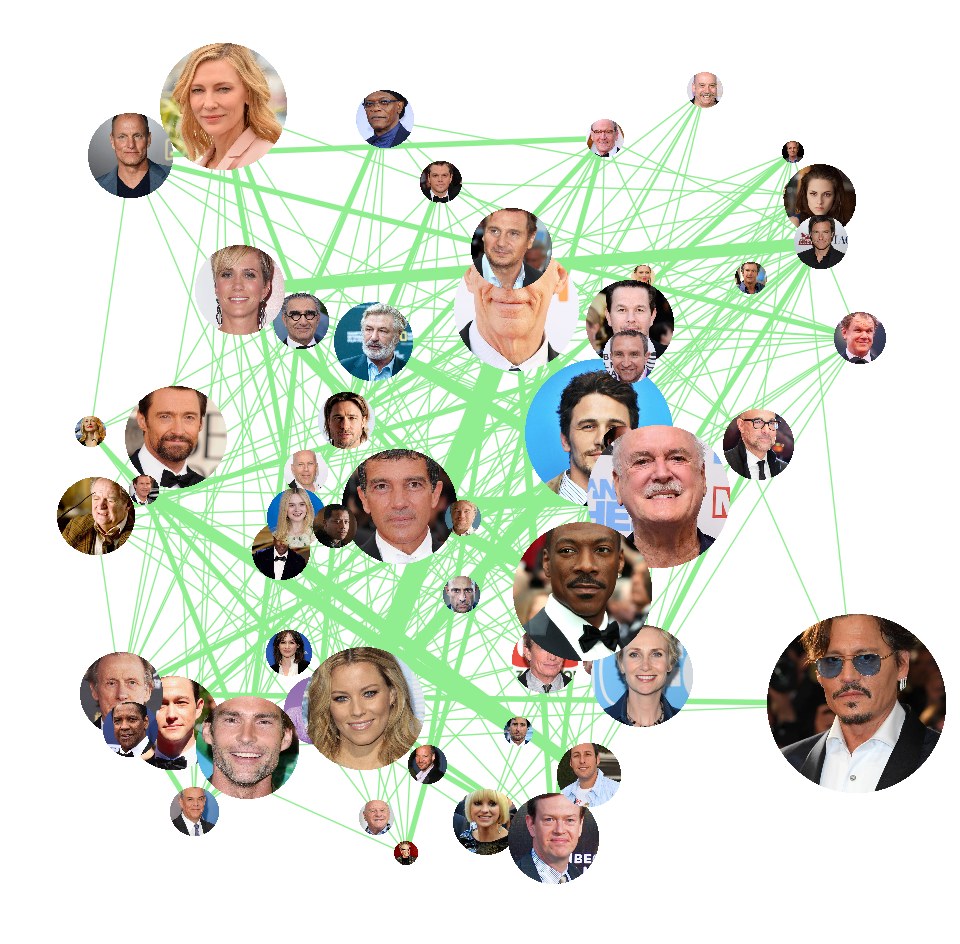

In [324]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw

# plot the graph with images of the actors as nodes

# create a dictionary that maps actor IDs to actor names
actor_names = characters.set_index("freebase_actor_ID")["actor_name"].to_dict()

# create a new dictionary that maps the actor IDs in the movies_binary_actors10 dataframe to the actor names
labels = {"freebase_actor_ID_" + actor: actor_names[actor] for actor in actor_names}

# create a figure
plt.figure(figsize=(12, 12))

# get the node sizes
node_sizes = nx.get_node_attributes(G, "size")

# get the edge weights
edge_weights = nx.get_edge_attributes(G, "weight")

# position the nodes randomly
pos = nx.random_layout(G, seed=3)

# iterate through the nodes in the graph
for node in G.nodes():
    # read the image file for this node
    img = Image.open(
        "./img/"
        + node.split("/m/")[0]
        + node.split("_ID_")[1].replace("/", ":")
        + ".jpg"
    )

    h, w = img.size
    # Resize the image to a square shape
    side_length = min(h, w)
    # crop the image to a square
    img = img.crop(
        (
            (h - side_length) // 2,
            (w - side_length) // 2,
            (h + side_length) // 2,
            (w + side_length) // 2,
        )
    )
    img = img.resize((800, 800))
    h, w = img.size

    # creating luminous image
    lum_img = Image.new("L", [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(0, 0), (h, w)], 0, 360, fill=255)
    img_arr = np.array(img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr, lum_img_arr))

    image = Image.fromarray(final_img_arr)

    # create an OffsetImage object for the image
    image_offset = OffsetImage(
        image, zoom=node_sizes[node] / 2000000000
    )  # , cmap=plt.cm.gray_r)

    # create an AnnotationBbox object for the image
    ab = AnnotationBbox(image_offset, pos[node], frameon=False)

    # add the AnnotationBbox to the plot
    plt.gca().add_artist(ab)

# draw the graph
nx.draw(
    G,
    pos=pos,
    with_labels=False,
    node_size=[node_sizes[v] / 500000 for v in G.nodes()],
    edge_color="lightgreen",
    width=[w**2 for _, _, w in G.edges(data="weight")],
    node_color="lightblue",
)

plt.show()

- We have created a flavor network graph where the nodes represent actors and the edges represent the movies that they have appeared in together. The size of the nodes reflects the average revenue of the movies that the actor has appeared in, while the width of the edges indicates the number of times that the actors have appeared in a movie together.
- This graph includes 61 actors and 256 connections. In the following section, we will delve deeper into this visualization to gain insights into the relationships between actors and their influence on revenue.

### Identify actor communities

- To gain a deeper understanding of the relationships depicted in our flavor network graph, we will utilize network analysis techniques to identify communities of actors who frequently appear in movies together and to measure the centrality of each actor in the network.

- To identify communities of actors, we will apply a network community detection algorithm. This will allow us to identify groups of actors who tend to appear in movies together and examine how these communities contribute to movie success. In particular, we will use the Louvain method to identify the "best" partition of communities in the network. By identifying these actor communities, we can gain a more detailed understanding of the patterns of collaboration and the impact of different actor combinations on movie revenue.

In [325]:
import community
import networkx as nx

# Use the Louvain method to detect communities in the graph
partition = community.best_partition(
    G,
    random_state=1,
    weight="weight",
)

communities = {}

# Print the actors in each community
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
        # communities[community_id].append(characters[characters['freebase_actor_ID'] == actor.split('_ID_')[1]]['actor_name'].values[0])

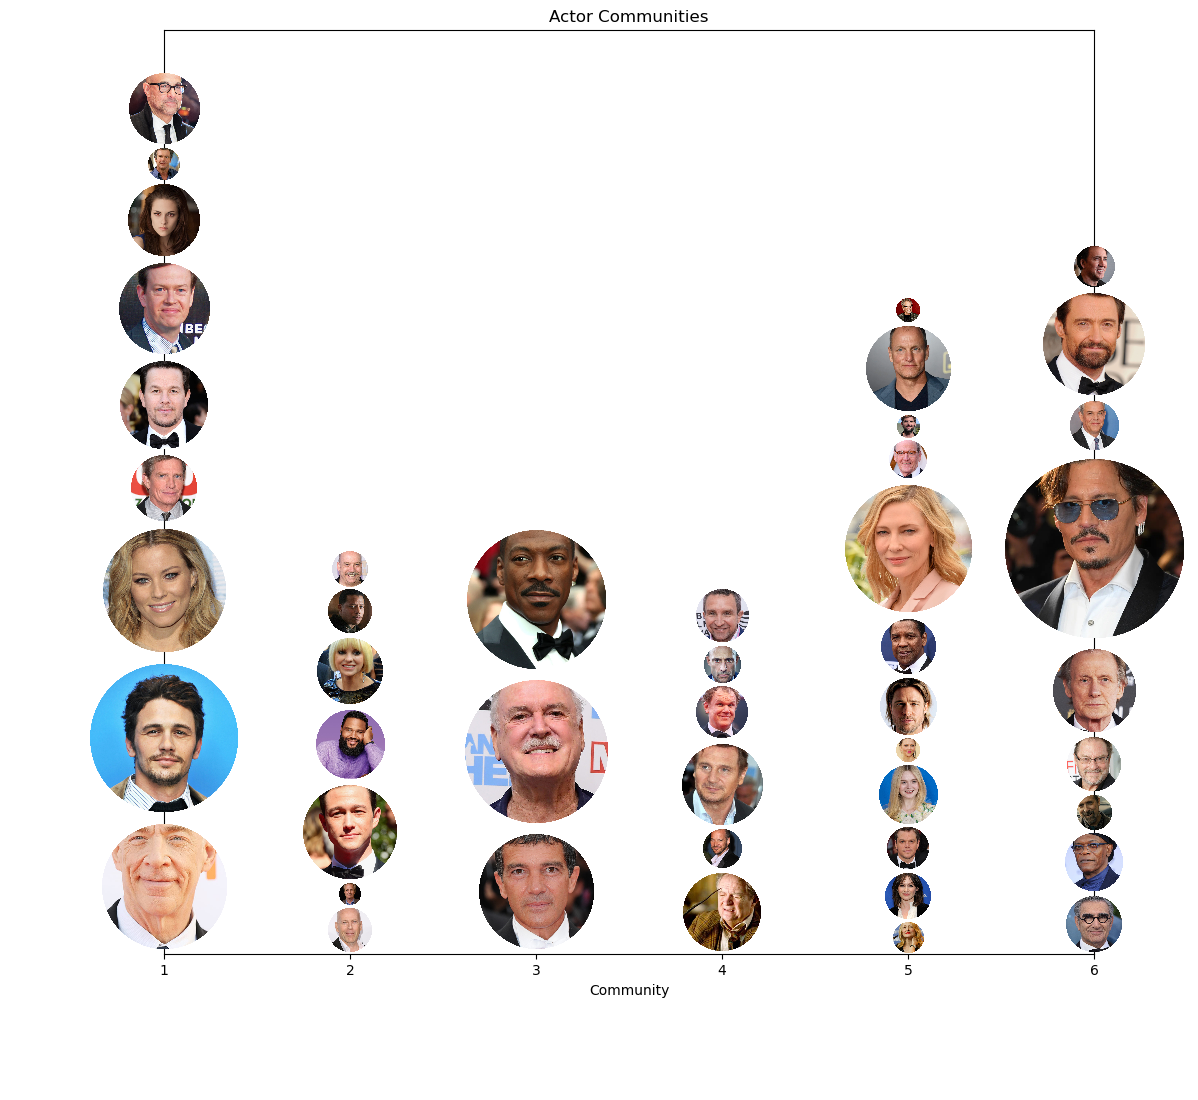

In [326]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# plot the graph with images of the actors as nodes

# create a dictionary that maps actor IDs to actor names
actor_names = characters.set_index("freebase_actor_ID")["actor_name"].to_dict()

# create a new dictionary that maps the actor IDs in the movies_binary_actors10 dataframe to the actor names
labels = {"freebase_actor_ID_" + actor: actor_names[actor] for actor in actor_names}

# create a figure
plt.figure(figsize=(12, 12))

# get the node sizes
node_sizes = nx.get_node_attributes(G, "size")

# iterate through the communities in the dictionary
for community, actor_ids in communities.items():
    # calculate the mean x and y coordinates for the actors in this community
    x_coord = community * 0.2
    y_coord = 0

    # read the image file for every actor in this community
    for idx, actor in enumerate(actor_ids):
        img = Image.open(
            "./img/"
            + actor.split("/m/")[0]
            + actor.split("_ID_")[1].replace("/", ":")
            + ".jpg"
        )

        h, w = img.size
        # Resize the image to a square shape
        side_length = min(h, w)
        # crop the image to a square
        img = img.crop(
            (
                (h - side_length) // 2,
                (w - side_length) // 2,
                (h + side_length) // 2,
                (w + side_length) // 2,
            )
        )
        img = img.resize((800, 800))
        h, w = img.size

        # creating luminous image
        lum_img = Image.new("L", [h, w], 0)
        draw = ImageDraw.Draw(lum_img)
        draw.pieslice([(0, 0), (h, w)], 0, 360, fill=255)
        img_arr = np.array(img)
        lum_img_arr = np.array(lum_img)
        final_img_arr = np.dstack((img_arr, lum_img_arr))

        image = Image.fromarray(final_img_arr)

        # create an OffsetImage object for the image
        image_offset = OffsetImage(image, zoom=node_sizes[actor] / 2000000000)

        # get width and height of the image
        height = image_offset.get_extent(renderer=plt.gcf().canvas.get_renderer())[0]

        y_coord += node_sizes[actor] / 3400000000

        # create an AnnotationBbox object for the image
        ab = AnnotationBbox(image_offset, (x_coord, y_coord), frameon=False)

        y_coord += node_sizes[actor] / 3400000000

        # add the AnnotationBbox to the plot
        plt.gca().add_artist(ab)

# draw the graph
plt.rcParamsDefault["font.size"] = "20"
plt.title("Actor Communities")
plt.xlabel("Community")

# remove y axis values
plt.gca().axes.get_yaxis().set_visible(False)

# change y axis limits
plt.ylim(0, 0.9)

# change the displayed x axis values
plt.xticks([x * 0.2 for x in range(6)], [x for x in range(1, 7)])

plt.show()

- Using the Louvain method, we have partitioned the network of actors into six distinct communities based on their connections through movies. This suggests that there are subgroups of actors who tend to work together more frequently. 
- Upon further analysis, we found that the average revenue generated by actors within each community varies, with some actors standing out as particularly successful in terms of average revenue.
- While we have not yet explored the potential reasons for these patterns, some possibilities could include the genre or type of film associated with each community, the fame or recognition of the actors within the industry, or the social connections between the actors. 
- For the purpose of our analysis, we are interested in examining how revenue is affected by including actors from different communities versus including actors from the same community. This will allow us to gain insights into the impact of actor combinations on movie revenue.

### Relationship between actor centrality and average revenue

To further understand the relationship between an actor's connections to other actors and their impact on movie revenue, we will examine the centrality of each actor in the network. To do this, we will create a scatterplot where the x-axis represents the degree centrality of each actor and the y-axis represents the average revenue of the movies that the actor has appeared in. This visualization will allow us to see if there is a relationship between an actor's centrality in the network and their average revenue-generating ability. This can provide insights into how an actor's connections to other actors may influence the success of a movie.

In [327]:
# Calulate degree centrality for each actor
degree_centrality = nx.degree_centrality(G)

To understand the role of actor connections in movie revenue, we will examine the degree centrality of each actor in the network. Degree centrality is a measure of the importance of a node in a network, which is defined by the number of connections the node has to other nodes. In the context of this flavor graph, degree centrality can be used to identify actors who have frequently appeared in different movie casts or who have worked with a wide variety of other actors.

We want to investigate whether it is beneficial for revenue to mix up the casts or to stick with actors from the same 'communities'. Mixing up the casts may bring in new audiences and offer fresh perspectives, but it may also be riskier as the actors may not have a pre-established fan base or may not have worked together before. On the other hand, sticking with actors from the same 'communities' may result in a more cohesive and familiar movie that appeals to a specific audience, but it may also limit the potential reach of the movie. Our analysis will help us understand the trade-offs between these different approaches and the impact of actor connections on movie revenue.

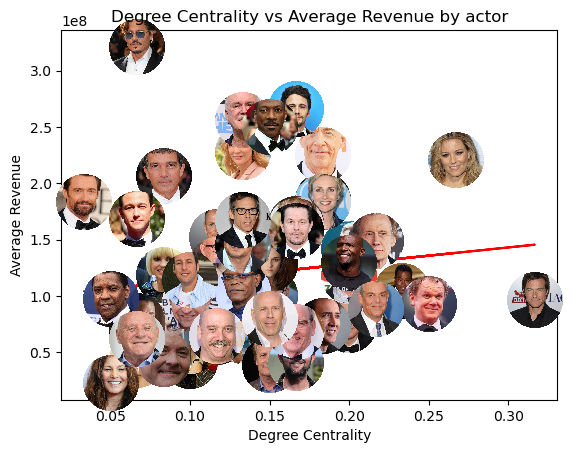

P-value:  0.3320912915703699


In [328]:
# Create a scatter plot for actors that have played in more than 15 movies

# Import the necessary modules
import matplotlib.image as mp
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image, ImageDraw
import os

# import polynomial regression
from scipy.stats import linregress

# Initialize dictionaries to store the average revenue and budget for each actor
actor_revenue = {}
actor_centrality = {}
actor_image_paths = {}

# Iterate over the actor columns
for col in movies_binary_actors10.columns:
    if col.startswith("freebase_actor_ID_/m/"):
        # print(col, ': ', characters[characters['freebase_actor_ID'] == col[18:]]['actor_name'].values[0])
        # Calculate the average revenue for this actor
        total_revenue = movies_binary_actors10[col].dot(
            movies_binary_actors10["movie_box_office_revenue"]
        )
        num_movies = movies_binary_actors10[col].sum()
        average_revenue = total_revenue / num_movies
        actor_revenue[col] = average_revenue
        actor_centrality[col] = degree_centrality[col]

        # Store the file path for the image to use for this actor
        actor_image_paths[col] = "./img/" + col.replace("/", ":") + ".jpg"
        # actor_image_paths[col] = "./johhny.jpg"

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over the actor data and add each image to the plot
for actor, image_path in actor_image_paths.items():
    # Read the image file
    # image = mpimg.imread(image_path)
    # checks if the image_path exists
    if os.path.exists(image_path):
        img = Image.open(image_path)
    else:
        print(actor)
        img = Image.open("./img/undefined.jpg")

    h, w = img.size
    # Resize the image to a square shape
    side_length = min(h, w)
    # crop the image to a square
    img = img.crop(
        (
            (h - side_length) // 2,
            (w - side_length) // 2,
            (h + side_length) // 2,
            (w + side_length) // 2,
        )
    )
    img = img.resize((800, 800))
    h, w = img.size

    # creating luminous image
    lum_img = Image.new("L", [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(0, 0), (h, w)], 0, 360, fill=255)
    img_arr = np.array(img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr, lum_img_arr))

    image = Image.fromarray(final_img_arr)

    # Create an OffsetImage object for the image
    image_offset = OffsetImage(image, zoom=0.05)

    # Create an AnnotationBbox object for the image
    ab = AnnotationBbox(
        image_offset, (actor_centrality[actor], actor_revenue[actor]), frameon=False
    )

    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)

# Use the scatter function to plot the data points
ax.scatter(actor_centrality.values(), actor_revenue.values())

# transform values of actor_centrality and actor revenue dict to list
actor_centrality_list = list(actor_centrality.values())
actor_revenue_list = list(actor_revenue.values())

# Fit a linear model to the data
slope, intercept, r_value, p_value, std_err = linregress(
    actor_centrality_list, actor_revenue_list
)

# Calculate the predicted values for the linear model
predicted_values = [slope * x + intercept for x in actor_centrality_list]

# Add the regression line to the plot in front of the scatter points
plt.plot(actor_centrality.values(), predicted_values, "r")

# set the font size
plt.rcParams["font.size"] = "10"
plt.rcParamsDefault["font.size"] = "10"

# Set the x and y labels and title
plt.xlabel("Degree Centrality")
plt.ylabel("Average Revenue")
plt.title("Degree Centrality vs Average Revenue by actor")

# save the plot
# plt.savefig('./saved_figures/actor_scatter_revenue_budget.png')

# Show the plot
plt.show()

print("P-value: ", p_value)

Our analysis of the relationship between degree centrality and average revenue for the actors showed a weak and insignificant relationship. This suggests that it may not be necessary to choose a cast from the same 'community' in order to achieve success. Instead, it could be just as beneficial to mix up the cast and create new combinations of actors. However, it is important to note that this conclusion is based on a weak relationship and further analysis is needed to fully understand the impact of actor connections on movie revenue.

For our next step in the analysis of actor communities, we will plot the initial flavor graph again, but this time we will distinguish between connections within communities and those between communities. This will allow us to see the patterns of collaboration within and between different actor communities and better understand the impact of these connections on movie revenue. 

/Users/torkelwestby/opt/anaconda3/envs/gpu/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


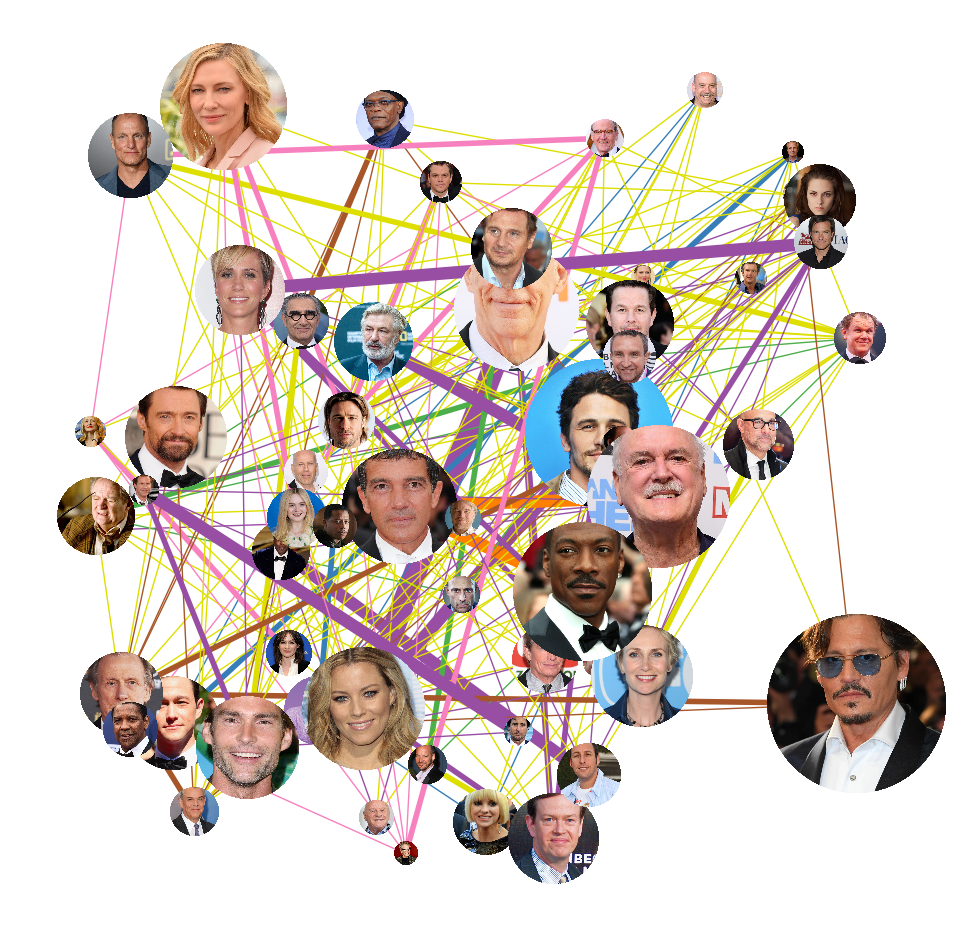

In [329]:
communities_ = {}

# Print the actors in each community
for actor, community_id in partition.items():
    communities_[actor] = community_id

# Create a list of edge colors, with edges within each community colored differently and edges between communities colored in purple
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3"]
edge_colors = [
    colors[communities_[u] - 1] if communities_[u] == communities_[v] else "#dede00"
    for u, v in G.edges()
]


# create a figure
plt.figure(figsize=(12, 12))

# iterate through the nodes in the graph
for node in G.nodes():
    # read the image file for this node
    img = Image.open(
        "./img/"
        + node.split("/m/")[0]
        + node.split("_ID_")[1].replace("/", ":")
        + ".jpg"
    )

    h, w = img.size
    # Resize the image to a square shape
    side_length = min(h, w)
    # crop the image to a square
    img = img.crop(
        (
            (h - side_length) // 2,
            (w - side_length) // 2,
            (h + side_length) // 2,
            (w + side_length) // 2,
        )
    )
    img = img.resize((800, 800))
    h, w = img.size

    # creating luminous image
    lum_img = Image.new("L", [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(0, 0), (h, w)], 0, 360, fill=255)
    img_arr = np.array(img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr, lum_img_arr))

    image = Image.fromarray(final_img_arr)

    # create an OffsetImage object for the image
    image_offset = OffsetImage(
        image, zoom=node_sizes[node] / 2000000000
    )  # , cmap=plt.cm.gray_r)

    # create an AnnotationBbox object for the image
    ab = AnnotationBbox(image_offset, pos[node], frameon=False)

    # add the AnnotationBbox to the plot
    plt.gca().add_artist(ab)

# draw the graph
nx.draw(
    G,
    pos=pos,
    with_labels=False,
    node_size=[node_sizes[v] / 500000 for v in G.nodes()],
    width=[w**2 for _, _, w in G.edges(data="weight")],
    cmap=plt.cm.RdYlBu,
    edge_color=edge_colors,
)
plt.show()

In this revised flavor plot, we have highlighted the edges that cross between two different actor communities in yellow. The other edges have a colour corresponding to their community. Our goal is to determine whether there is a difference in revenue when creating a movie cast with actors from a single community versus actors from multiple communities. To do this, we will analyze the patterns of collaboration within and between communities and examine the impact of these connections on movie revenue. Let's delve deeper into this analysis!

To gain a deeper understanding of the relationships between actors and their impact on revenue, we will divide the movies into two categories: those with a cast that is largely concentrated within a single actor community, and those with a cast that is more evenly distributed among multiple communities. This will enable us to compare the performance of movies with more homogenous casts versus those with more diverse casts, and determine whether there is a relationship between cast composition and revenue. By analyzing these two categories of movies, we can gain insights into the potential benefits and drawbacks of casting actors from a single community versus a mix of communities, and how this may impact the success of a movie.

In [330]:
import pandas as pd

# Create a list of the column names of the actor columns
actor_columns = [
    col
    for col in movies_binary_actors10.columns
    if col.startswith("freebase_actor_ID_")
]

# Create empty lists to store the movies with a majority of actors from one community and movies with actors more spread between the communities
majority_community_movies = []
spread_community_movies = []
i = 0
j = 0
top_communities = []
# Iterate over the rows of the dataframe
for _, row in movies_binary_actors10.iterrows():
    # count the total number of actors in the movie
    total_count = row[actor_columns].sum()

    # Count the number of actors who belong to each community by summing the values in the actor columns
    community_counts_0 = row[communities[0]].sum()
    community_counts_1 = row[communities[1]].sum()
    community_counts_2 = row[communities[2]].sum()
    community_counts_3 = row[communities[3]].sum()
    community_counts_4 = row[communities[4]].sum()
    community_counts_5 = row[communities[5]].sum()

    community_counts = [
        community_counts_0,
        community_counts_1,
        community_counts_2,
        community_counts_3,
        community_counts_4,
        community_counts_5,
    ]

    # Determine which community has the most actors in the movie
    max_community = np.array(community_counts).argmax()

    top_communities.append(max_community)

    # Number of actors from a community is greater than half of the total number of actors
    # or number of actors from a community is greater half of the total number of actors in this community
    if community_counts[max_community] > total_count / 2 or any(
        community_counts[i] > community_counts[i] / 2 for i in range(6)
    ):
        # code to execute if the condition is True
        majority_community_movies.append(row)
    # Otherwise, add it to the list of movies with actors more spread between the communities
    else:
        spread_community_movies.append(row)

# Print the number of movies in each list

print(
    """
    Number of movies that have a majority of actors from one community or contain more than half of one community: {}
    Number of movies that have actors more spread between the communities: {}
    """.format(
        len(majority_community_movies), len(spread_community_movies)
    )
)


    Number of movies that have a majority of actors from one community or contain more than half of one community: 419
    Number of movies that have actors more spread between the communities: 824
    


To start our analysis, we will compare the average revenue of movies with a cast that is largely concentrated within a single actor community (majority_community_movies) to the average revenue of movies with a cast that is more evenly distributed among multiple communities (spread_community_movies). This will give us a baseline understanding of any potential differences in revenue between these two groups of movies. By comparing the average revenue of these two categories of movies, we can begin to examine the relationship between cast composition and revenue. 

In [331]:
# Create a dataframe from the list of movies with a majority of actors from one community
majority_community_movies_df = pd.DataFrame(majority_community_movies)

# Create a dataframe from the list of movies with actors more spread between the communities
spread_community_movies_df = pd.DataFrame(spread_community_movies)

print(
    """
    Average revenue made for the movies that have a majority of actors from one community or contain more than half of one community: {}
    Average revenue made for the movies that have actors more spread between the communities: {}
    """.format(
        majority_community_movies_df["movie_box_office_revenue"].mean(),
        spread_community_movies_df["movie_box_office_revenue"].mean(),
    )
)


    Average revenue made for the movies that have a majority of actors from one community or contain more than half of one community: 105838096.63827102
    Average revenue made for the movies that have actors more spread between the communities: 54217171.94591937
    


We observe a significant difference in the average revenue between movies with a cast that is largely concentrated within a single community and those with a more evenly distributed cast. To more accurately assess the impact of cast composition on revenue, it is important to consider other factors that could influence the results. One way to control for these potential confounds is through the use of matching, which allows us to compare movies with similar characteristics. By controlling for these other factors, we can more confidently attribute any observed differences in revenue to the effect of cast composition. This will help us better understand the relationship between cast composition and movie revenue and identify any trends or patterns.

In [332]:
# Create a new column in each dataframe to indicate whether the movie has a majority of actors from one community or not
majority_community_movies_df["majority_community"] = 1
spread_community_movies_df["majority_community"] = 0

# Concatenate the two dataframes
community_movies_df = pd.concat(
    [majority_community_movies_df, spread_community_movies_df]
)

# add the necesary columns to the dataframe to perform matching
# add column for number of languages
community_movies_df["num_languages"] = community_movies_df["movie_languages"].apply(
    get_num_elements
)

# add column for number of countries
community_movies_df["num_countries"] = community_movies_df["movie_countries"].apply(
    get_num_elements
)

# convert genres to dictionary
community_movies_df["movie_genres"] = community_movies_df["movie_genres"].apply(
    ast.literal_eval
)

# reset index
community_movies_df.reset_index(inplace=True), community_movies_df.drop(
    "index", axis=1, inplace=True
)

# print the results
community_movies_df.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,freebase_actor_ID_/m/0h7pj,freebase_actor_ID_/m/0jfx1,freebase_actor_ID_/m/0mdqp,freebase_actor_ID_/m/0pmhf,freebase_actor_ID_/m/0pz91,freebase_actor_ID_/m/0z4s,freebase_actor_ID_/m/0zcbl,majority_community,num_languages,num_countries
0,6305925,/m/0g08ws,The Astronaut Farmer,2006-10-15,9.508027e+06,104.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{'/m/06n90': 'Science Fiction', '/m/09n5t_': '...",2006,...,1,0,0,0,0,0,0,1,2,1


In [333]:
# store data fram before standardization
community_movies_df_original = community_movies_df.copy()

# standardize the continuous variables
movies_one_hot_genres_actors["movie_runtime"] = (
    movies_one_hot_genres_actors["movie_runtime"]
    - movies_one_hot_genres_actors["movie_runtime"].mean()
) / movies_one_hot_genres_actors["movie_runtime"].std()
movies_one_hot_genres_actors["year_released"] = (
    movies_one_hot_genres_actors["year_released"]
    - movies_one_hot_genres_actors["year_released"].mean()
) / movies_one_hot_genres_actors["year_released"].std()
movies_one_hot_genres_actors["num_languages"] = (
    movies_one_hot_genres_actors["num_languages"]
    - movies_one_hot_genres_actors["num_languages"].mean()
) / movies_one_hot_genres_actors["num_languages"].std()
movies_one_hot_genres_actors["num_countries"] = (
    movies_one_hot_genres_actors["num_countries"]
    - movies_one_hot_genres_actors["num_countries"].mean()
) / movies_one_hot_genres_actors["num_countries"].std()
movies_one_hot_genres_actors["budget"] = (
    movies_one_hot_genres_actors["budget"]
    - movies_one_hot_genres_actors["num_countries"].mean()
) / movies_one_hot_genres_actors["budget"].std()

In [334]:
# compute propensity score
formula = "majority_community ~  movie_runtime + year_released + num_languages + num_countries"

mod = smf.logit(formula=formula, data=community_movies_df)

res = mod.fit()

community_movies_df["propensity_score"] = res.predict(
    community_movies_df[
        ["movie_runtime", "year_released", "num_languages", "num_countries"]
    ]
)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.621793
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     majority_community   No. Observations:                 1243
Model:                          Logit   Df Residuals:                     1238
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.02706
Time:                        16:09:28   Log-Likelihood:                -772.89
converged:                       True   LL-Null:                       -794.38
Covariance Type:            nonrobust   LLR p-value:                 1.041e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -25.3089     34.177     -0.741      0.459     -92.294      41.676
movie_runtime     0.

In [335]:
# try matching with requirement on genre and similarity
treatment_df = community_movies_df[community_movies_df["majority_community"] == 1]
control_df = community_movies_df[community_movies_df["majority_community"] == 0]

# our treatment df is the majority community movies
# our control df is the movies with more spread actors

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity
        similarity = get_similarity(
            control_row["propensity_score"], treatment_row["propensity_score"]
        )

        if (
            shared_value(control_row["movie_genres"], treatment_row["movie_genres"])
            and similarity > 0.95
        ):
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching_ethnicity = nx.max_weight_matching(G)

In [336]:
# collect matched instances
matched_community = [i[0] for i in list(matching_ethnicity)] + [
    i[1] for i in list(matching_ethnicity)
]

In [337]:
# create the balanced dataset
balanced_communities_df = community_movies_df_original.iloc[matched_community].copy()
print(balanced_communities_df.shape)
balanced_communities_df.head(1)

(830, 83)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,freebase_actor_ID_/m/0h7pj,freebase_actor_ID_/m/0jfx1,freebase_actor_ID_/m/0mdqp,freebase_actor_ID_/m/0pmhf,freebase_actor_ID_/m/0pz91,freebase_actor_ID_/m/0z4s,freebase_actor_ID_/m/0zcbl,majority_community,num_languages,num_countries
459,2311219,/m/072x7s,Munich,2005-12-23,1.149450e+08,164.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{'/m/01jfsb': 'Thriller', '/m/01f9r0': 'Docudr...",2005,...,0,0,0,0,0,0,0,0,8,3


In our initial dataset, we had a total of 419 movies with a spread movie cast and 824 movies with a majority community cast. After applying matching techniques to control for potential confounders, we narrowed down the dataset to include 408 movies with a spread movie cast and 409 movies with a majority community cast. While we did lose some data in the matching process, the resulting dataset allows for a more robust analysis by minimizing the potential influence of confounding variables on the results. This will help us more accurately assess the relationship between cast composition and movie revenue and identify any trends or patterns.

In [338]:
# declares the model without balanced data
mod_naive = smf.ols(
    formula="movie_box_office_revenue ~ majority_community", data=community_movies_df
)

# fits the model
res_naive = mod_naive.fit()

# declares the model without balanced data
mod_match = smf.ols(
    formula="movie_box_office_revenue ~ majority_community",
    data=balanced_communities_df,
)

# fits the model
res_match = mod_match.fit()

# print the coefficent for the treatment
print(
    f"""
    Coefficient for the treatment without matching:     {round(res_naive.params['majority_community'], 1)}
    Coefficient for the treatment with matching:         {round(res_match.params['majority_community'], 1)}
    Difference in percent:                                 {round((res_match.params['majority_community'] - res_naive.params['majority_community'])/res_naive.params['majority_community']*100, 2)}%
    
    p-value for the treatment without matching:          {round(res_naive.pvalues['majority_community'], 3)}
    p-value for the treatment with matching:             {round(res_match.pvalues['majority_community'], 3)}
    """
)


    Coefficient for the treatment without matching:     51620924.7
    Coefficient for the treatment with matching:         39424016.7
    Difference in percent:                                 -23.63%
    
    p-value for the treatment without matching:          0.0
    p-value for the treatment with matching:             0.0
    


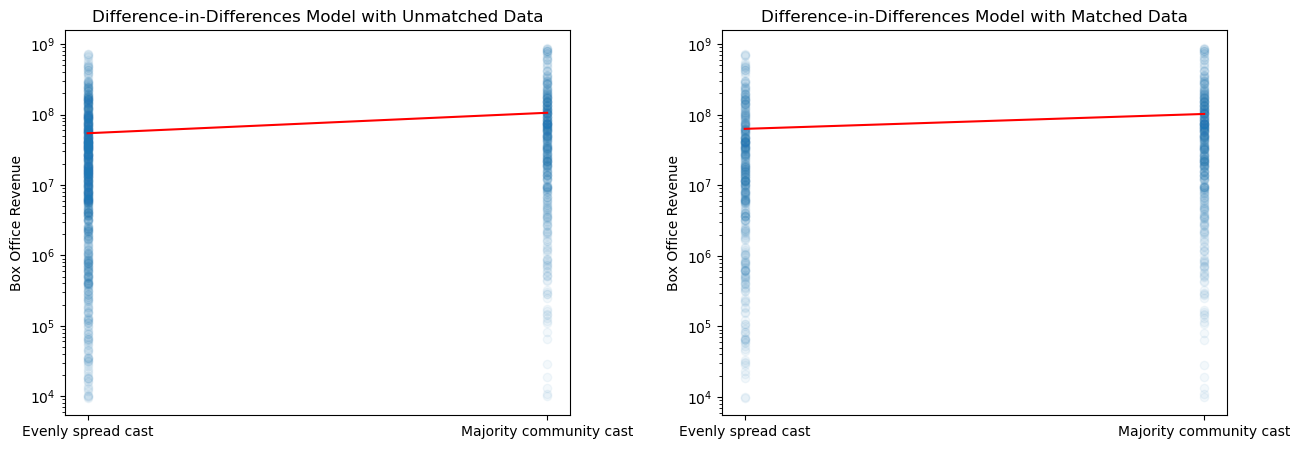

In [345]:
# plot the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot the previous difference-in-differences model with labels
axs[0].scatter(
    community_movies_df["majority_community"],
    community_movies_df["movie_box_office_revenue"],
    alpha=0.05,
)
axs[0].plot(
    community_movies_df["majority_community"], res_naive.fittedvalues, color="red"
)

axs[1].scatter(
    balanced_communities_df["majority_community"],
    balanced_communities_df["movie_box_office_revenue"],
    alpha=0.05,
)
axs[1].plot(
    balanced_communities_df["majority_community"], res_match.fittedvalues, color="red"
)

# set log scale
axs[0].set_yscale("log")
axs[1].set_yscale("log")

# set the title
axs[0].set_title("Difference-in-Differences Model with Unmatched Data")
axs[1].set_title("Difference-in-Differences Model with Matched Data")

# set y label of figure
axs[0].set_ylabel("Box Office Revenue")
axs[1].set_ylabel("Box Office Revenue")

# set the x ticks
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(["Evenly spread cast", "Majority community cast"])
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(["Evenly spread cast", "Majority community cast"])

# add some distance between the subplots
plt.subplots_adjust(wspace=0.3)

# show the plot
plt.show()

Our revised difference-in-differences analysis revealed that movies with a majority of actors from a specific community have a significant impact on box office revenue. The treatment effect was substantial in both estimates, with and without matching, at $51620924.7 and $39424016.7, respectively. The difference between the two estimates was approximately -23.63%, and both estimates were statistically significant with a p-value of 0.0.

In this analysis, we chose to exclude budget as a matching variable because it is likely closely related to actor cast. Using budget as a matching variable could potentially control for the effect of the actor cast, making it difficult to determine the independent effect of the actor cast on revenue. However, budget is an important factor that can influence a movie's production value and overall appeal to audiences. For example, a movie with a high budget may be more likely to generate revenue due to a larger marketing budget and wider distribution.

Although we do not have data on how budgets were specifically allocated for each movie, we speculate that a significant portion of the film's budget is often used for casting. It is possible that it is more costly to assemble a cast primarily from one community.

Our purpose in this analysis was to examine the effect of actor cast on revenue, so we chose to exclude budget as a matching variable.

# Runtime

- This section intends to investigate the runtime of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of runtime and how it correlates with a movie's revenue.

---
### Summary
- We cannot conclude there is a linear relationship between movie runtime and revenue.
- Blockbuster movies ($400 million+) have, on average, 10.1% longer runtime than non-blockbuster movies.
- Movies with short runtime (<80min) have 54.8% less revenue than non-short movies.

---
### Data Processing

---
#### Loading data

In [65]:
# Filter for movies with runtime
df_runtime = movies[movies["movie_runtime"].notnull()]

---
#### Outlier Removal
We will find outliers by calculating IQR and remove data outside the lower/upper bound.

In [66]:
# IQR
Q1 = np.percentile(df_runtime["movie_runtime"], 25)
Q3 = np.percentile(df_runtime["movie_runtime"], 75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Remove outlier
df_runtime = df_runtime[
    (df_runtime["movie_runtime"] >= lower) & (df_runtime["movie_runtime"] <= upper)
]
df_runtime.head(1)

,index,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,...,budget,id,release_date,tconst,averageRating,numVotes,date_given,release_year,release_month,genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,1.362575e+07,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",...,2.723042e+07,10016,2001-08-24 00:00:00+00:00,tt0228333,4.9,55271.0,True,2001.0,8.0,"[Thriller, Science Fiction, Horror, Adventure,..."


---
### Distribution of runtime

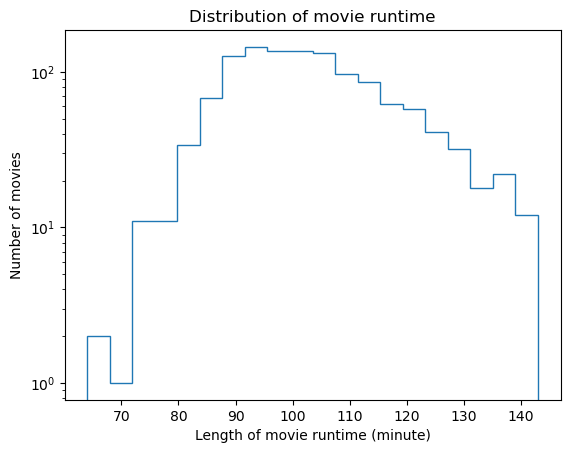

In [67]:
# histogram plot
plt.hist(df_runtime["movie_runtime"], histtype="step", log=True, bins=20)
plt.title("Distribution of movie runtime")
plt.xlabel("Length of movie runtime (minute)")
plt.ylabel("Number of movies")
plt.show()

#### Comment

From the log histogram, we can see that most of the movies have runtime within the 85-120 minute interval.

---
### Regression & Scatterplot

In [68]:
runtime_model = smf.ols(
    "movie_box_office_revenue ~ movie_runtime", data=df_runtime
).fit()

# summarize our model
runtime_model_summary = runtime_model.summary()
runtime_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.049
Model:                                  OLS   Adj. R-squared:                  0.048
Method:                       Least Squares   F-statistic:                     62.69
Date:                      Tue, 20 Dec 2022   Prob (F-statistic):           5.37e-15
Time:                              10:23:16   Log-Likelihood:                -24546.
No. Observations:                      1231   AIC:                         4.910e+04
Df Residuals:                          1229   BIC:                         4.911e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.178e+08   2.33e+07     -5.055      0.000   -1.63e+08   -7.21e+07
movie_runtime  1.765e+06   2.23e+05      7.918      0.000    1.33e+06     2.2e+06
==============================================================================
Omnibus:                      926.107   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14476.304
Skew:                           3.445   Prob(JB):                         0.00
Kurtosis:                      18.322   Cond. No.                         772.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

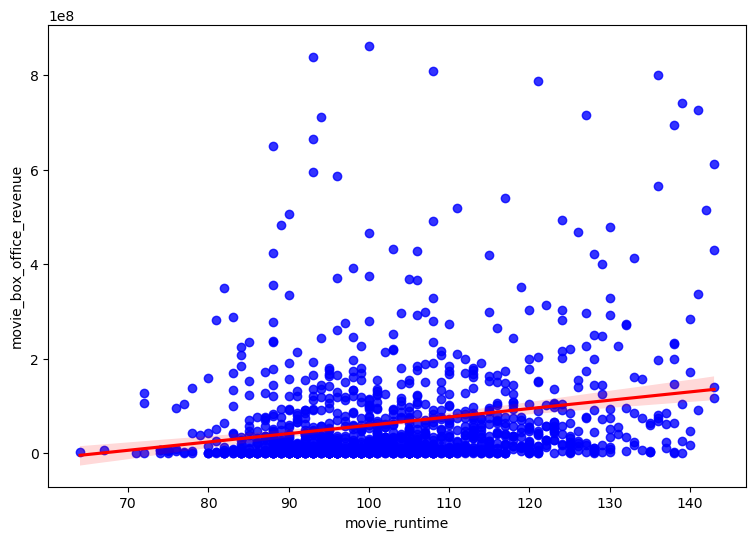

In [69]:
fig = plt.figure(figsize=(9, 6))

# pass in the model as the first parameter, then specify the
# predictor variable we want to analyze
fig = sns.regplot(
    x="movie_runtime",
    y="movie_box_office_revenue",
    data=df_runtime,
    ci=95,
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)

#### Comment
- From the scatterplot, we see that there is a slight positive linear relationship between runtime and revenue. 
- However from previous regression analysis, the R squared value (0.035) is too small to justify the dependency between runtime and revenue. 
- We also see that movie with runtime between 80-120 minutes have similar distribution of revenue and movies with runtime less than 80 minutes generate less revenue (highet revenue is below $400000000). - Thus we can raise the question that if 80 minute could be a threshold for movie's revenue performance and we will address it in the next section.

---
### Effect of short runtime on revenue
We define **short** movie to have runtime < 80min\
and other (non-short) movie to have runtime >= 80min.

In [70]:
# Filter short movie to be under 80min
df_short = df_runtime[df_runtime["movie_runtime"] < 80]

# Filter non-short movie to be above or equal to 80min
df_non_short = df_runtime[df_runtime["movie_runtime"] >= 80]

In [71]:
# independent t-test between short and non-short movies
stats.ttest_ind(
    a=df_short["movie_box_office_revenue"],
    b=df_non_short["movie_box_office_revenue"],
    equal_var=False,
)

Ttest_indResult(statistic=-3.884778450243202, pvalue=0.0005076219742532862)

In [72]:
# calculate mean difference
mean_diff = (
    df_short["movie_box_office_revenue"].mean()
    - df_non_short["movie_box_office_revenue"].mean()
)

# print the mean difference
print(f"The mean difference in revenue is: {mean_diff}")

The mean difference in revenue is: -37408978.01232927


In [73]:
# calculating the percentage difference in revenue between the mean and non-short
diff_percent = mean_diff / df_non_short["movie_box_office_revenue"].mean()

# printing the results
diff_percent

-0.5687451514880617

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.
- Further, the mean difference tells us that short movies (< 80min) generally generates less revenue than non-short (>=80min) movies.
- We can conclude that movies should not be too short as short movies have 54.8% less revenue than non-short movies.

---
### Difference in runtime between blockbuster vs. non-blockbuster
We define **blockbusters** as movies with revenue >= 400 million USD\
and **non-blockbusters** as movies with revenue < 400 million USD.

In [74]:
# Filter blockbuster movies
df_bb = df_runtime[df_runtime["movie_box_office_revenue"] >= 400000000]

# Filter non-blockbuster movies
df_non_bb = df_runtime[df_runtime["movie_box_office_revenue"] < 400000000]

In [75]:
# independent t-test
stats.ttest_ind(a=df_bb["movie_runtime"], b=df_non_bb["movie_runtime"], equal_var=False)

Ttest_indResult(statistic=3.7339588470130525, pvalue=0.0006893832491792914)

In [76]:
# calculate mean difference
mean_diff = df_bb["movie_runtime"].mean() - df_non_bb["movie_runtime"].mean()

# print the mean difference
print(f"The mean difference in runtime is: {mean_diff}")

The mean difference in runtime is: 12.328910511573056


In [77]:
# calculating the percentage difference in runtime between the mean and non-blockbuster
diff_percent = mean_diff / df_non_bb["movie_runtime"].mean()

# printing the results
diff_percent

0.11946560687076888

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that the blockbuster runtime is generally longer than non-blockbuster.  
- We can conclude that longer runtime are more successful, as blockbuster movies have 10.05% longer runtime than non-blockbuster movies. 

# Plot Summary

- This section intends to investigate the plot summary of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the sentiments within plot summary of movies and how they correlate with a movie's revenue.

---
### Summary
- We analyze plot summary from three sentiments: positive, negative and violent words and analyze if their proportion in plot summary affects revenue.
- Movies with more negative plot have on average 45.3% more revenue than those with more positive plots.
- Movies with more violent plot are more likely to generate revenue since blockbuster movies have 36.9% higher violent word porportion than non-blockbuster movies.

---
### Data Processing

---
#### Loading data

In [78]:
# Read summary data and filter movies with summary not null
df_summary = pd.read_csv(
    PLOT_SUMMARIES_PATH, sep="\t", header=None, names=["wikipedia_movie_ID", "summary"]
)
df_summary = df_summary[df_summary["summary"].notnull()]

In [79]:
# Merge metadata and summary data and filter for revenue and summary
df_merge = pd.merge(movies, df_summary, on=["wikipedia_movie_ID"], how="inner")
df_merge = df_merge[["wikipedia_movie_ID", "summary", "movie_box_office_revenue"]]
df_merge.head(5)

,wikipedia_movie_ID,summary,movie_box_office_revenue
0,975900,"Set in the second half of the 22nd century, th...",1.362575e+07
1,6305925,Charles Farmer is a former astronaut-in-traini...,9.508027e+06
2,5254729,"{{Expand section}} Rosie , a scriptwriter for ...",7.953377e+06
3,19168185,This is the story of two lads from Belfast as ...,2.469102e+04
4,1226289,Maggie O'Connor's life revolves around her jo...,4.044301e+07


---
#### Positive / Negative / Violent Vocab Collection
We decide to examine if positivity, negativity and violence in plot will affect movie revenue.\
First, we collect vocabulary with positive, negative and violent connotation.

In [80]:
# Sentiment List
sentiment = ["positive", "negative", "violent"]

In [81]:
# collecting the positive words list

# requesting the url
r = requests.get(POSITIVE_WORDS_PATH)

# extracting and decoding the content from the request
text = r.content.decode("us-ascii")

# extracting the text containing the positive words
pos_text = text.split("\n\n")

# converting the text into a list
pos_list = pos_text[1].split("\n")

In [82]:
# collecting the neagative words list

# requesting the url
r = requests.get("https://ptrckprry.com/course/ssd/data/negative-words.txt")

# extracting and decoding the content from the request
text = r.content.decode("iso-8859-1")

# extracting the text containing the negative words
neg_text = text.split("\n\n")

# converting the text into a list
neg_list = neg_text[1].split("\n")

In [83]:
# collecting the violence words list
# source: https://myvocabulary.com/word-list/violence-vocabulary/

# Read from txt file
violent_file = open(VIOLENT_WORDS_PATH, "r")
violent_words = violent_file.read()

# Split into list
vio_list = violent_words.split(", ")

# Map every word into lower case
vio_list = list(map(lambda x: x.lower(), vio_list))

---
#### Positive / Negative / Violent proportion in summary
We calculate the proportion of words with positive / negative / violent connotation out of all words in movie summary.

In [84]:
# adding column for positive sentiment
df_merge["positive"] = df_merge["summary"].apply(lambda x: check_summary(x, pos_list))

# adding a columns for negative sentiment
df_merge["negative"] = df_merge["summary"].apply(lambda x: check_summary(x, neg_list))

# adding a columns for violent sentiment
df_merge["violent"] = df_merge["summary"].apply(lambda x: check_summary(x, vio_list))

In [85]:
df_merge.head(2)

,wikipedia_movie_ID,summary,movie_box_office_revenue,positive,negative,violent
0,975900,"Set in the second half of the 22nd century, th...",1.362575e+07,0.005602,0.044818,0.033613
1,6305925,Charles Farmer is a former astronaut-in-traini...,9.508027e+06,0.023490,0.033557,0.043624


---
### Regression & Scatterplot

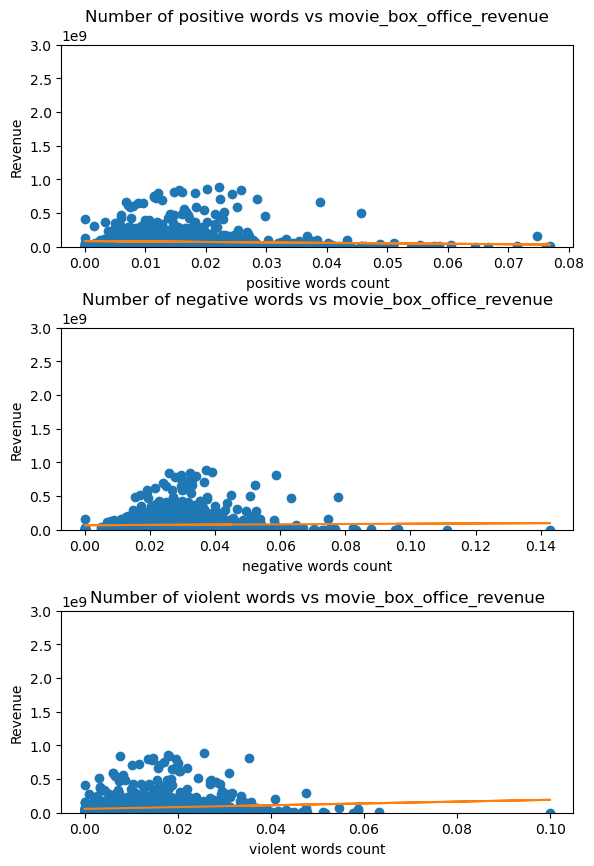

In [86]:
fig, ax = plt.subplots(3, 1)

# sentiment to ax position mapping
sen2ax = {"positive": ax[0], "negative": ax[1], "violent": ax[2]}

# Plot for each sentiment: positive, negative, violent
for s in sentiment:
    ax = sen2ax[s]
    ax.plot(df_merge[s], df_merge["movie_box_office_revenue"], "o")

    # obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(df_merge[s], df_merge["movie_box_office_revenue"], 1)
    # add linear regression line to scatterplot
    ax.plot(df_merge[s], m * df_merge[s] + b)

    ax.set_title(f"Number of {s} words vs movie_box_office_revenue")
    ax.set_xlabel(f"{s} words count")
    ax.set_ylabel("Revenue")
    ax.set_ylim(0, 3000000000)

# Combine all the operations and display
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1.7, wspace=0.4, hspace=0.4)
plt.show()

In [87]:
# Regression analysis for positive word proportion vs revenue
positive_revenue_model = smf.ols(
    "movie_box_office_revenue ~ positive", data=df_merge
).fit()
positive_revenue_model_summary = positive_revenue_model.summary()
positive_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.003
Model:                                  OLS   Adj. R-squared:                  0.002
Method:                       Least Squares   F-statistic:                     3.629
Date:                      Tue, 20 Dec 2022   Prob (F-statistic):             0.0570
Time:                              10:24:04   Log-Likelihood:                -23776.
No. Observations:                      1183   AIC:                         4.756e+04
Df Residuals:                          1181   BIC:                         4.757e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.543e+07   6.95e+06     12.284      0.000    7.18e+07    9.91e+07
positive   -6.704e+08   3.52e+08     -1.905      0.057   -1.36e+09       2e+07
==============================================================================
Omnibus:                      869.577   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11387.599
Skew:                           3.406   Prob(JB):                         0.00
Kurtosis:                      16.587   Cond. No.                         93.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
# Regression analysis for negative word proportion vs revenue
negative_revenue_model = smf.ols(
    "movie_box_office_revenue ~ negative", data=df_merge
).fit()
negative_revenue_model_summary = negative_revenue_model.summary()
negative_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.6199
Date:                      Tue, 20 Dec 2022   Prob (F-statistic):              0.431
Time:                              10:24:04   Log-Likelihood:                -23778.
No. Observations:                      1183   AIC:                         4.756e+04
Df Residuals:                          1181   BIC:                         4.757e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    6.78e+07   9.07e+06      7.474      0.000       5e+07    8.56e+07
negative    2.192e+08   2.78e+08      0.787      0.431   -3.27e+08    7.65e+08
==============================================================================
Omnibus:                      863.336   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11072.023
Skew:                           3.380   Prob(JB):                         0.00
Kurtosis:                      16.376   Cond. No.                         73.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# Regression analysis for violent word proportion vs revenue
violence_revenue_model = smf.ols(
    "movie_box_office_revenue ~ violent", data=df_merge
).fit()
violence_revenue_model_summary = violence_revenue_model.summary()
violence_revenue_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.011
Model:                                  OLS   Adj. R-squared:                  0.010
Method:                       Least Squares   F-statistic:                     12.95
Date:                      Tue, 20 Dec 2022   Prob (F-statistic):           0.000333
Time:                              10:24:04   Log-Likelihood:                -23772.
No. Observations:                      1183   AIC:                         4.755e+04
Df Residuals:                          1181   BIC:                         4.756e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.705e+07   6.09e+06      9.373      0.000    4.51e+07     6.9e+07
violent     1.347e+09   3.74e+08      3.599      0.000    6.13e+08    2.08e+09
==============================================================================
Omnibus:                      855.289   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10794.715
Skew:                           3.342   Prob(JB):                         0.00
Kurtosis:                      16.204   Cond. No.                         99.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comment
- From the scatterplot, we see that there is a negative linear relationship between positive word proportion and revenue. In contrast, there is a positive linear relationship between negative word proportion and revenue. There is also a positive linear relationship between violent word proportion and revenue. 
- However from previous regression analysis, the R squared value (0.004 - positive, 0.000 - negative, 0.008 - violent) is too small to justify the dependency between all sentiments and revenue. 
- We see a opposing relationship between positive and negative plots and we will discover if more positive plot or more negative plot can boost the revenue in the following section.

---
### Difference in revenues between movies with more positive and more negative plot
We will analyze if plots with more positive word proportions will generate more revenues than those with more negative word proportions. 

In [90]:
# Filter for movies that have higher proportion of positive words than negative words
df_pos_majority = df_merge[df_merge["positive"] > df_merge["negative"]]

# Filter for movies that higher proportion of negative words than positive words
df_neg_majority = df_merge[df_merge["negative"] > df_merge["positive"]]

In [91]:
# independent t-test
stats.ttest_ind(
    a=df_pos_majority["movie_box_office_revenue"],
    b=df_neg_majority["movie_box_office_revenue"],
    equal_var=False,
)

Ttest_indResult(statistic=-5.822739521119145, pvalue=1.037154505100019e-08)

In [92]:
# calculate mean difference
mean_diff = (
    df_pos_majority["movie_box_office_revenue"].mean()
    - df_neg_majority["movie_box_office_revenue"].mean()
)

# print the mean difference
print(f"The mean difference in revenue is: {mean_diff}")

The mean difference in revenue is: -41037063.24090443


In [93]:
# calculating the percentage difference in revenue between the mean and negative
diff_percent = mean_diff / df_neg_majority["movie_box_office_revenue"].mean()

# printing the results
diff_percent

-0.49620691463229233

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.
- Further, the mean difference tells us that movies with more positive plot generally has less revenue than movies with more negative plot.
- We can conclude that movies with more negative plot are more successful, as movies with more negative plot have 45.3% more revenue than movies with more positive plot.

---
### Difference in sentiment proportion between blockbuster vs. non-blockbuster
We define **blockbusters** as movies with revenue >= 400 million USD\
and **non-blockbusters** as movies with revenue < 400 million USD.

In [94]:
# Filter blockbuster movies
df_bb = df_merge[df_merge["movie_box_office_revenue"] >= 400000000]

# Filter non-blockbuster movies
df_non_bb = df_merge[df_merge["movie_box_office_revenue"] < 400000000]

In [95]:
# For each sentiment
for s in sentiment:
    # independent t-test
    print(stats.ttest_ind(a=df_bb[s], b=df_non_bb[s], equal_var=False))

    # calculate mean difference
    mean_diff = df_bb[s].mean() - df_non_bb[s].mean()

    # print the mean difference
    print(f"The mean difference in proportion of {s} words in summary is: {mean_diff}")

    # calculating the percentage difference between the mean and non-blockbuster
    diff_percent = mean_diff / df_non_bb[s].mean()

    # printing the results
    print(
        f"The percentage mean difference in proportion of {s} words in summary between blockbuster and non-blockbuster is: {diff_percent * 100}%\n"
    )

Ttest_indResult(statistic=0.1397283549183967, pvalue=0.8894574217252793)
The mean difference in proportion of positive words in summary is: 0.0001902605017474468
The percentage mean difference in proportion of positive words in summary between blockbuster and non-blockbuster is: 1.1460944012097103%

Ttest_indResult(statistic=1.7912146764200763, pvalue=0.07966686408643074)
The mean difference in proportion of negative words in summary is: 0.0033676367616537056
The percentage mean difference in proportion of negative words in summary between blockbuster and non-blockbuster is: 11.41298008683022%

Ttest_indResult(statistic=3.4300318556496188, pvalue=0.0012395136004550527)
The mean difference in proportion of violent words in summary is: 0.004194179450964666
The percentage mean difference in proportion of violent words in summary between blockbuster and non-blockbuster is: 33.173295749460195%



#### Positive
- The independent t-test for positive words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has smaller positive word proportion in summary than non-blockbuster.  
- We can conclude that less positive plot components are more successful, as blockbuster movies have 10.2% less positive word usage than non-blockbuster movies. 

#### Negative
- The independent t-test for negative words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher negative word proportion in summary than non-blockbuster.  
- We can conclude that more negative plot components are more successful, as blockbuster movies have 12.4% more negative word proportion than non-blockbuster movies. 

#### Violent
- The independent t-test for violent words gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples.  
- Further, the mean difference tells us that blockbuster movies generally has higher violent word proportion in summary than non-blockbuster.  
- We can conclude that more violent plot components are more successful as blockbuster movies have 36.9% higher violent word proportion than non-blockbuster movies. 